### Import Required Libraries

In [1]:
# !pip install -r requirements.txt --q 

In [2]:
import pandas as pd # Python library for data analysis and data frame
import numpy as np # Numerical Python library for linear algebra and computations

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = (12, 8); # setting the figuresize 

from datetime import datetime, date #Library to deal with datetime columns

# time series analysis libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# time series forecasting libraries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# Neural network required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# model evaluation libraries
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#for saving trained model
import pickle

import warnings
warnings.filterwarnings("ignore") # To prevent kernel from showing any warning

/Users/a0s0j0u/anaconda3/envs/forecast_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importing Time Series Data

- Tabular Data
- Web Time Series Data

In [3]:
# Tabular Structured Data Importing
df = pd.read_csv('data/Daily_Delhi_Climate_Train_v2.csv',index_col='date') # loading the data 
print(df.shape)
df.head()

(1462, 4)


,meantemp,humidity,wind_speed,meanpressure
date,,,,
01/01/13,10.000000,84.500000,0.000000,1015.666667
02/01/13,7.400000,92.000000,2.980000,1017.800000
03/01/13,7.166667,87.000000,4.633333,1018.666667
04/01/13,8.666667,71.333333,1.233333,1017.166667
05/01/13,6.000000,86.833333,3.700000,1016.500000


In [4]:
from pandas_datareader import wb

countries = ["IN", "CN"]
population_df = wb.download(indicator="SP.POP.TOTL", country=countries, start=2010, end=2020)
population_df.head()

SP.POP.TOTL
country year             
China   2020   1411100000
        2019   1407745000
        2018   1402760000
        2017   1396215000
        2016   1387790000

### Time Series Data Analysis & Preparation
- Visual Inspection : Through Time Series Plots
- Missing Value Treatment
- Time Series Decomposition : Trend, Seasonality, Noise
- Stationarity Check

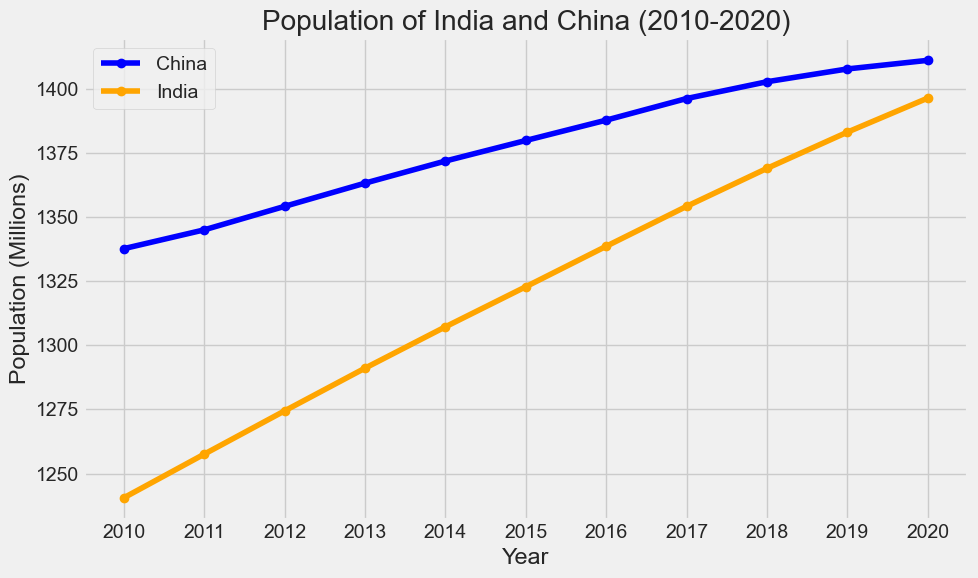

In [5]:
# Plot the population for both India and China over the years
plt.figure(figsize=(10,6))

population_df = population_df.reset_index().sort_values(['country','year'])
# Plot for China
plt.plot(population_df[population_df['country'] == 'China']['year'],
         population_df[population_df['country'] == 'China']['SP.POP.TOTL'] / 1e6,
         marker='o', label="China", color='blue')

# Plot for India
plt.plot(population_df[population_df['country'] == 'India']['year'],
         population_df[population_df['country'] == 'India']['SP.POP.TOTL'] / 1e6,
         marker='o', label="India", color='orange')

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Population (Millions)")
plt.title("Population of India and China (2010-2020)")

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

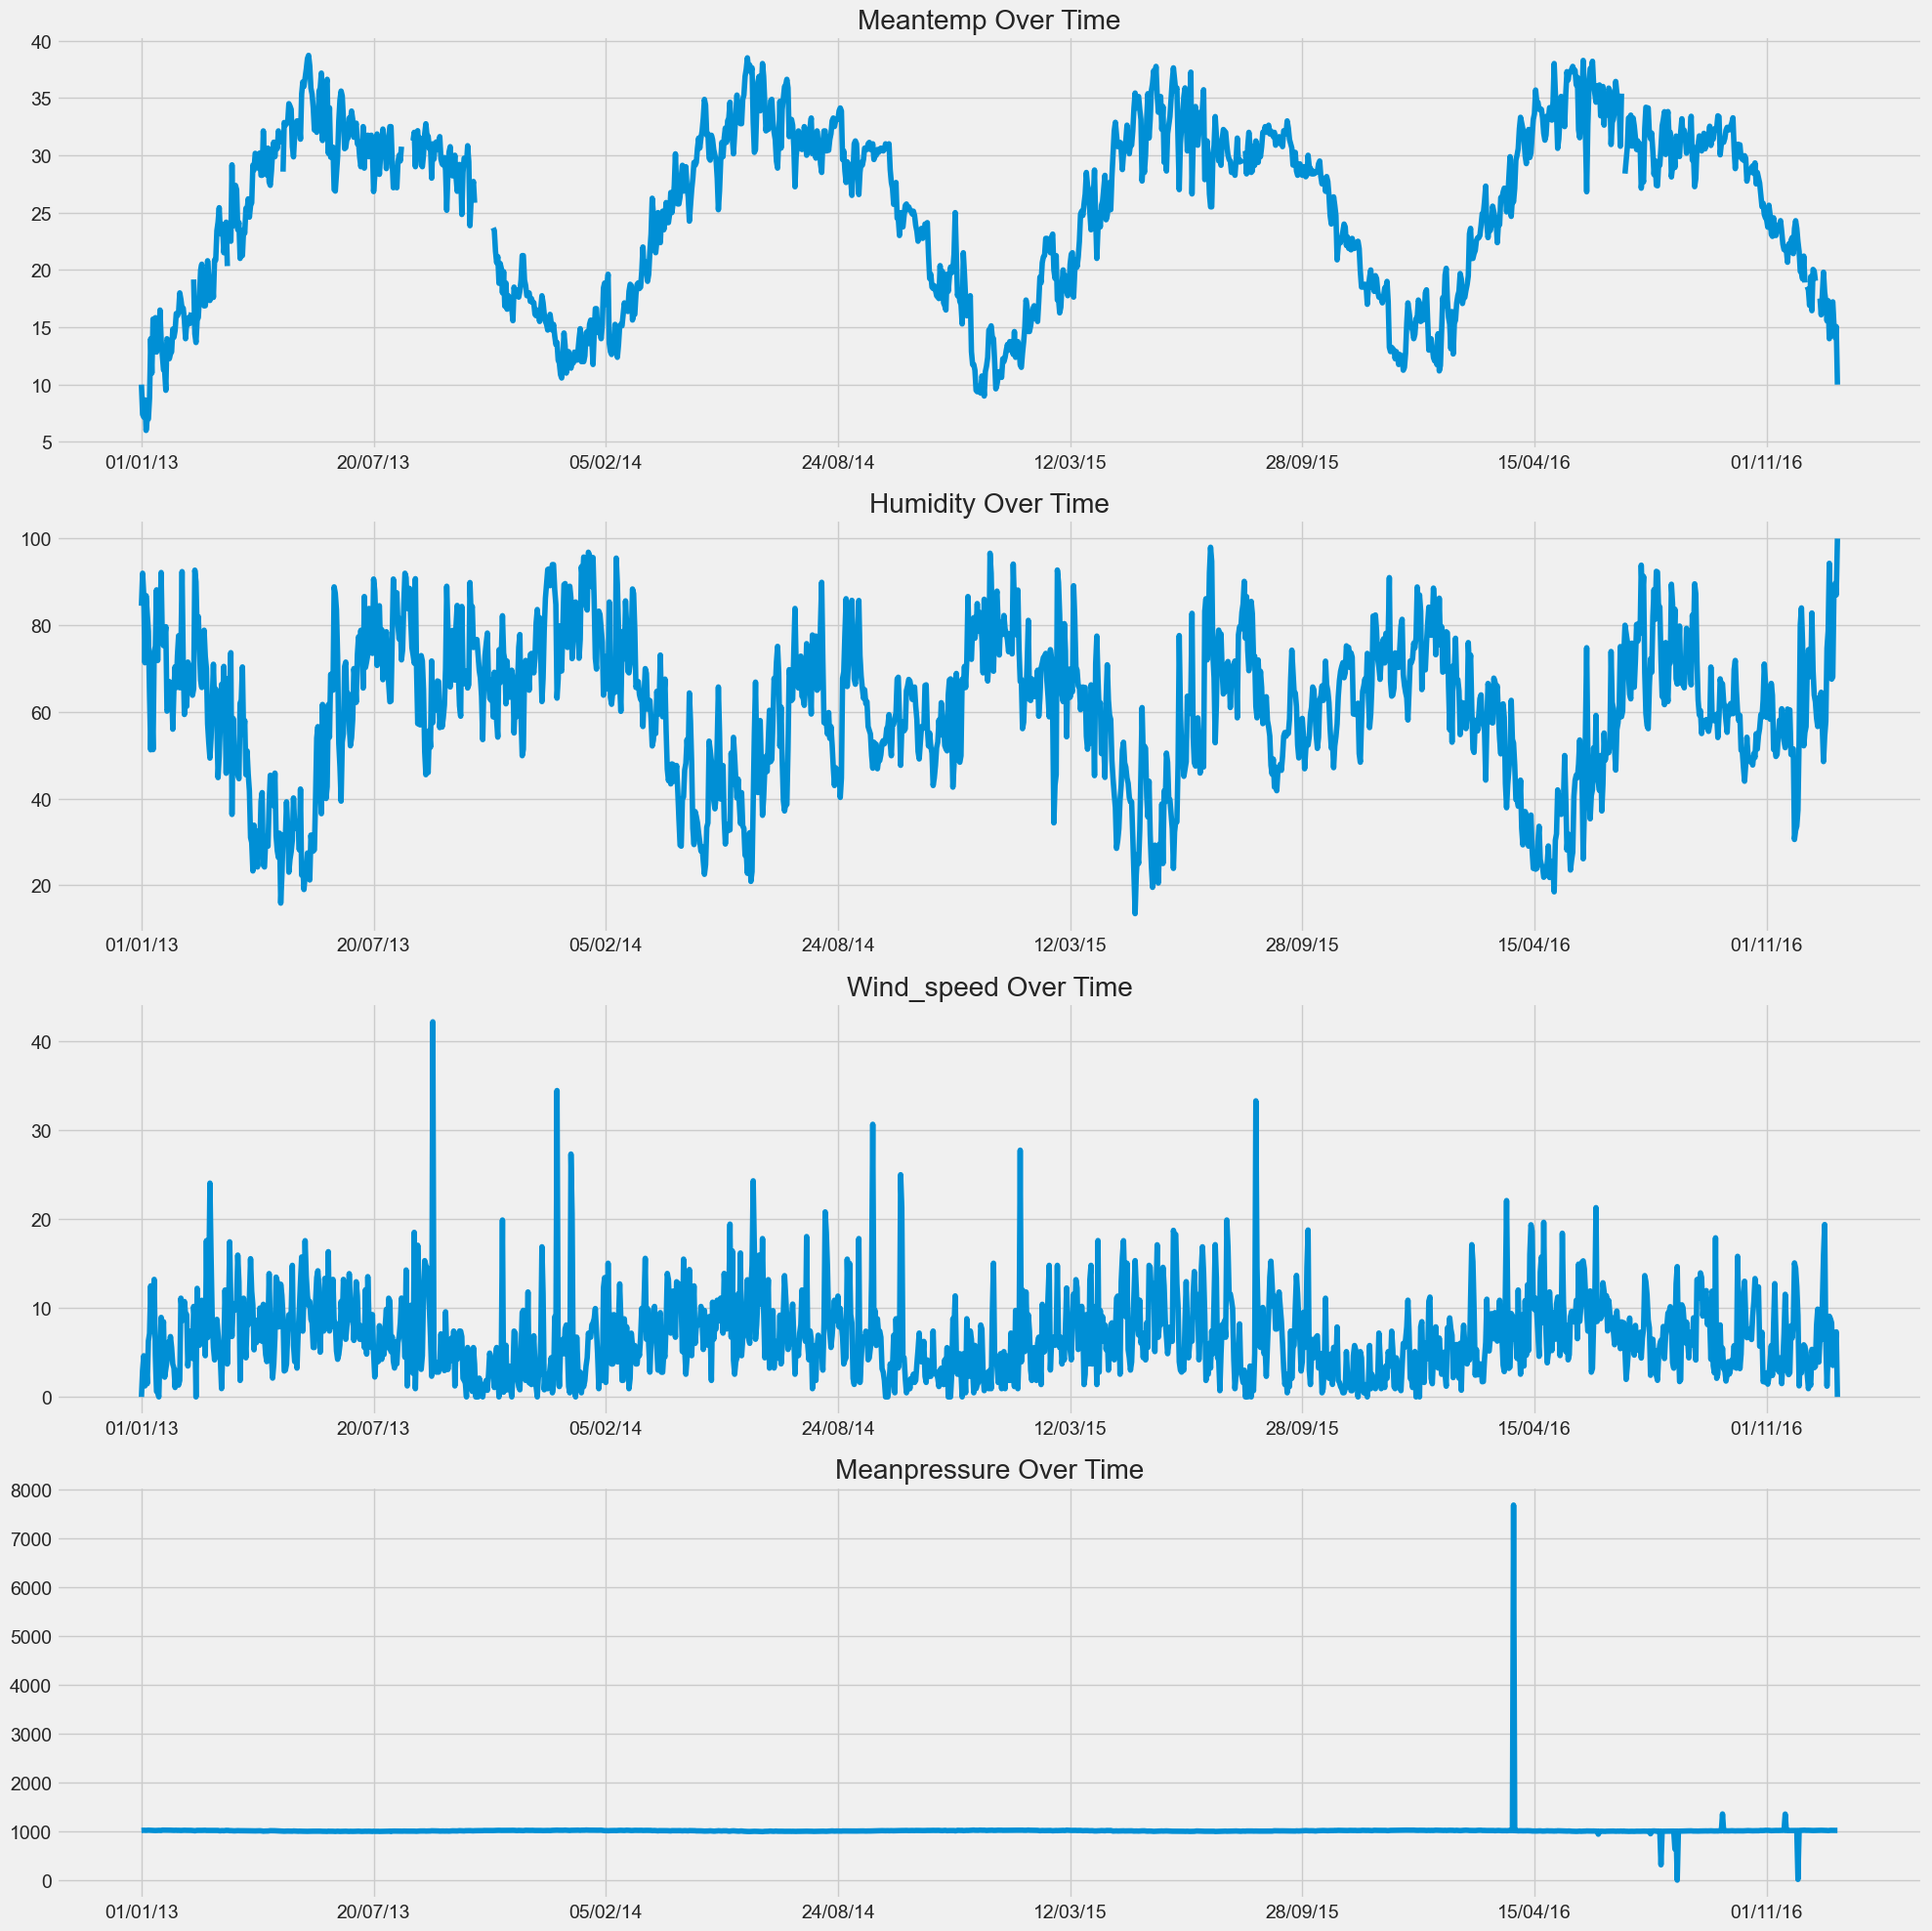

In [6]:
import matplotlib.pyplot as plt

# Time series variables
ts_vars = list(df.columns)

# Create a figure with the number of subplots equal to the number of time series variables
plt.figure(figsize=(20, 20))  # Adjust height according to the number of subplots

# Loop through each variable and create a subplot
for i, var in enumerate(ts_vars, 1):  # Starts from index 1 for subplot position
    plt.subplot(len(ts_vars), 1, i)  # len(ts_vars) rows, 1 column, i-th subplot
    df[var].plot()
    plt.ylabel(None)  # Optional: to remove the y-label
    plt.xlabel(None)  # Optional: to remove the x-label
    plt.title(f"{var.capitalize()} Over Time")
    plt.tight_layout()

# Display the plots
plt.show()


### Missing Value Treatment

In [7]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())


Missing Values in Each Column:
meantemp        35
humidity         0
wind_speed       0
meanpressure     0
dtype: int64


In [8]:
# 1. Forward Fill
df_ffill = df.ffill()

# 2. Backward Fill
df_bfill = df.bfill()

# 3. Linear Interpolation
df_interp = df.interpolate(method='linear')

# 4. Moving Average (Window=3)
df_ma = df.fillna(df.rolling(window=30, min_periods=1).mean())

# 5. Rolling Window Mean (Window=3)
df_rolling = df.fillna(df.rolling(window=30, min_periods=1).mean())

# Display missing values after imputation
print("\nMissing Values After Imputation (Forward Fill):")
print(df_ffill.isnull().sum())

print("\nMissing Values After Imputation (Backward Fill):")
print(df_bfill.isnull().sum())

print("\nMissing Values After Imputation (Linear Interpolation):")
print(df_interp.isnull().sum())

print("\nMissing Values After Imputation (Moving Average):")
print(df_ma.isnull().sum())

print("\nMissing Values After Imputation (Rolling Window):")
print(df_rolling.isnull().sum())


Missing Values After Imputation (Forward Fill):
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Missing Values After Imputation (Backward Fill):
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Missing Values After Imputation (Linear Interpolation):
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Missing Values After Imputation (Moving Average):
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Missing Values After Imputation (Rolling Window):
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


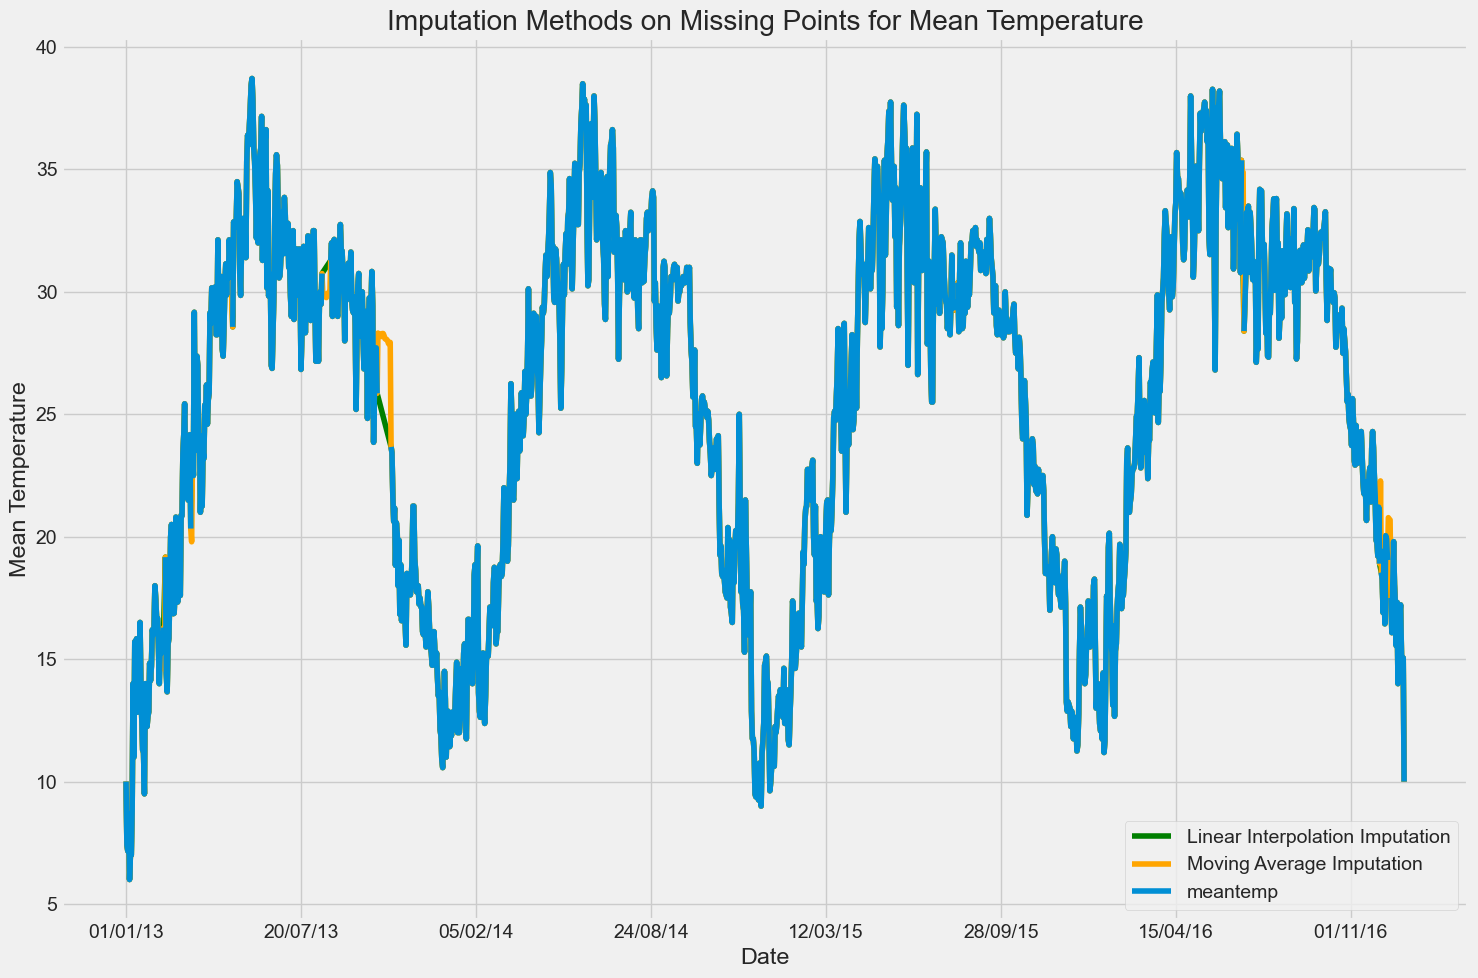

In [9]:
import matplotlib.pyplot as plt

# Mask for missing values in the original data
missing_mask = df['meantemp'].isnull()

# Plot original series
plt.figure(figsize=(15,10))
# Plot Imputed Series
df_interp['meantemp'].plot(label="Linear Interpolation Imputation",color="green")
df_ma['meantemp'].plot(label="Moving Average Imputation",color="orange")
df['meantemp'].plot()


# Format x-axis for dates
plt.title('Imputation Methods on Missing Points for Mean Temperature')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Outlier Treatment

['meantemp', 'humidity', 'wind_speed', 'meanpressure']


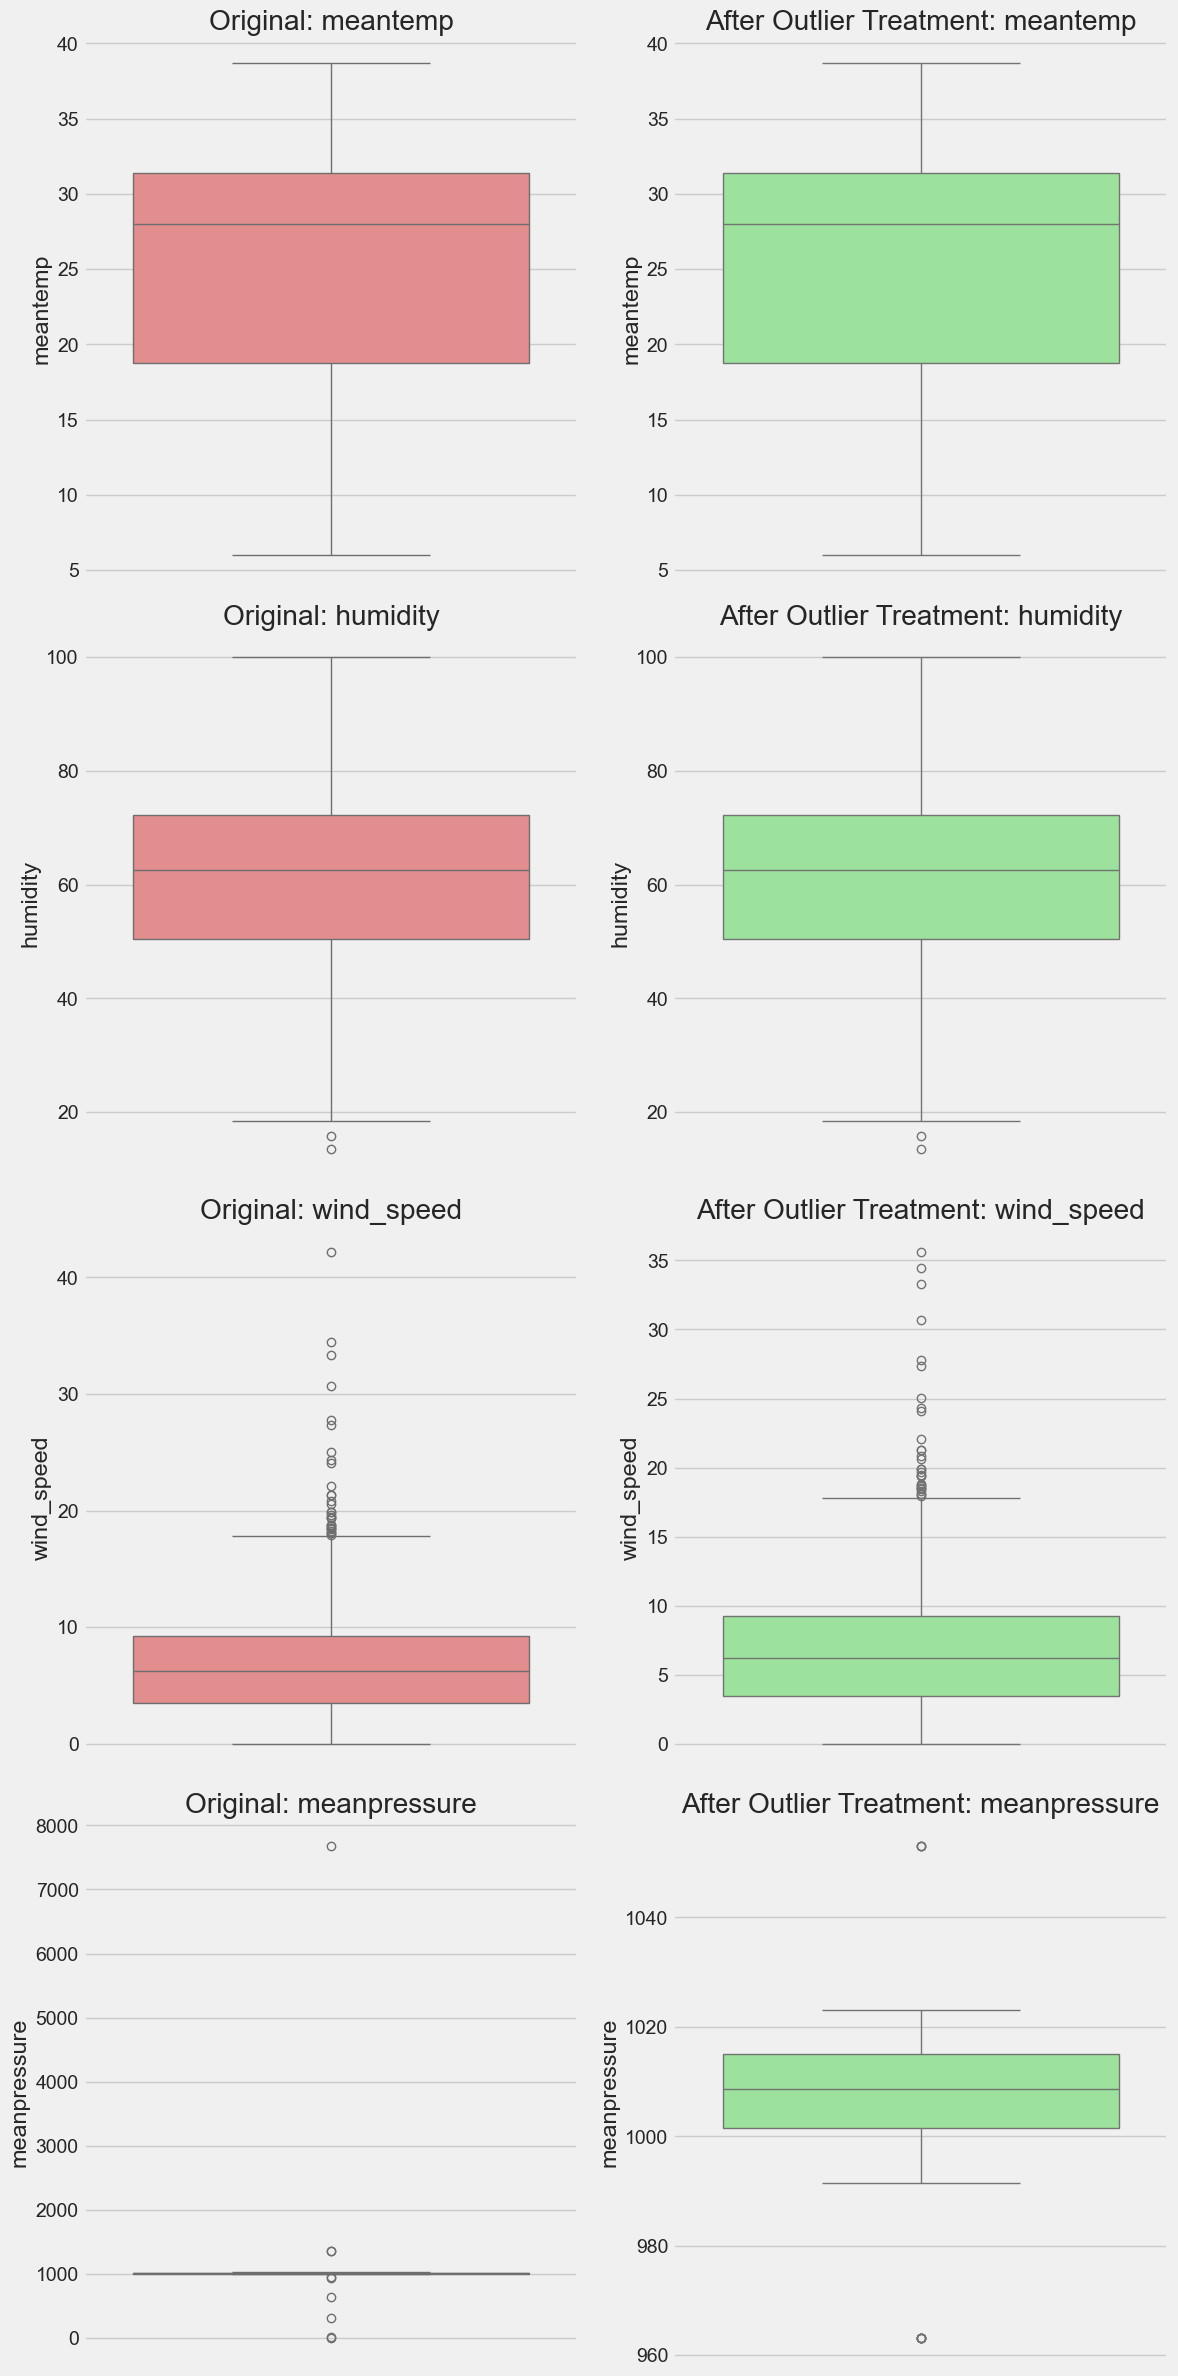

In [10]:
import pandas as pd

# Define the columns to check for outliers
print(ts_vars)

# Function to detect and treat outliers using IQR method
def treat_outliers_iqr(df, columns):
    # Loop through each column
    for col in columns:
        # Calculate Lower Bound (5th percentile) and Upper Bound (95th percentile)
        QL = df[col].quantile(0.05)
        QU = df[col].quantile(0.95)
        # Calculate IQR (Interquartile Range)
        IQR = QU - QL
        # Define lower bound and upper bound
        lower_bound = QL - 1.5 * IQR
        upper_bound = QU + 1.5 * IQR
        # Treatment: Replace outliers with the boundary values
        df[col] = df[col].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    
    return df

# Visualize the outliers before and after treatment using boxplots
def plot_outliers(df_original, df_cleaned, columns):
    fig, axes = plt.subplots(len(columns), 2, figsize=(12, 6 * len(columns)))
    
    for i, col in enumerate(columns):
        # Original boxplot with outliers
        sns.boxplot(data=df_original, y=col, ax=axes[i, 0], color='lightcoral')
        axes[i, 0].set_title(f'Original: {col}')
        axes[i, 0].set_ylabel(col)

        # Boxplot after treatment
        sns.boxplot(data=df_cleaned, y=col, ax=axes[i, 1], color='lightgreen')
        axes[i, 1].set_title(f'After Outlier Treatment: {col}')
        axes[i, 1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

# Treat outliers
df_cleaned = treat_outliers_iqr(df.copy(), ts_vars)

# Visualize before and after treatment
plot_outliers(df, df_cleaned, ts_vars)

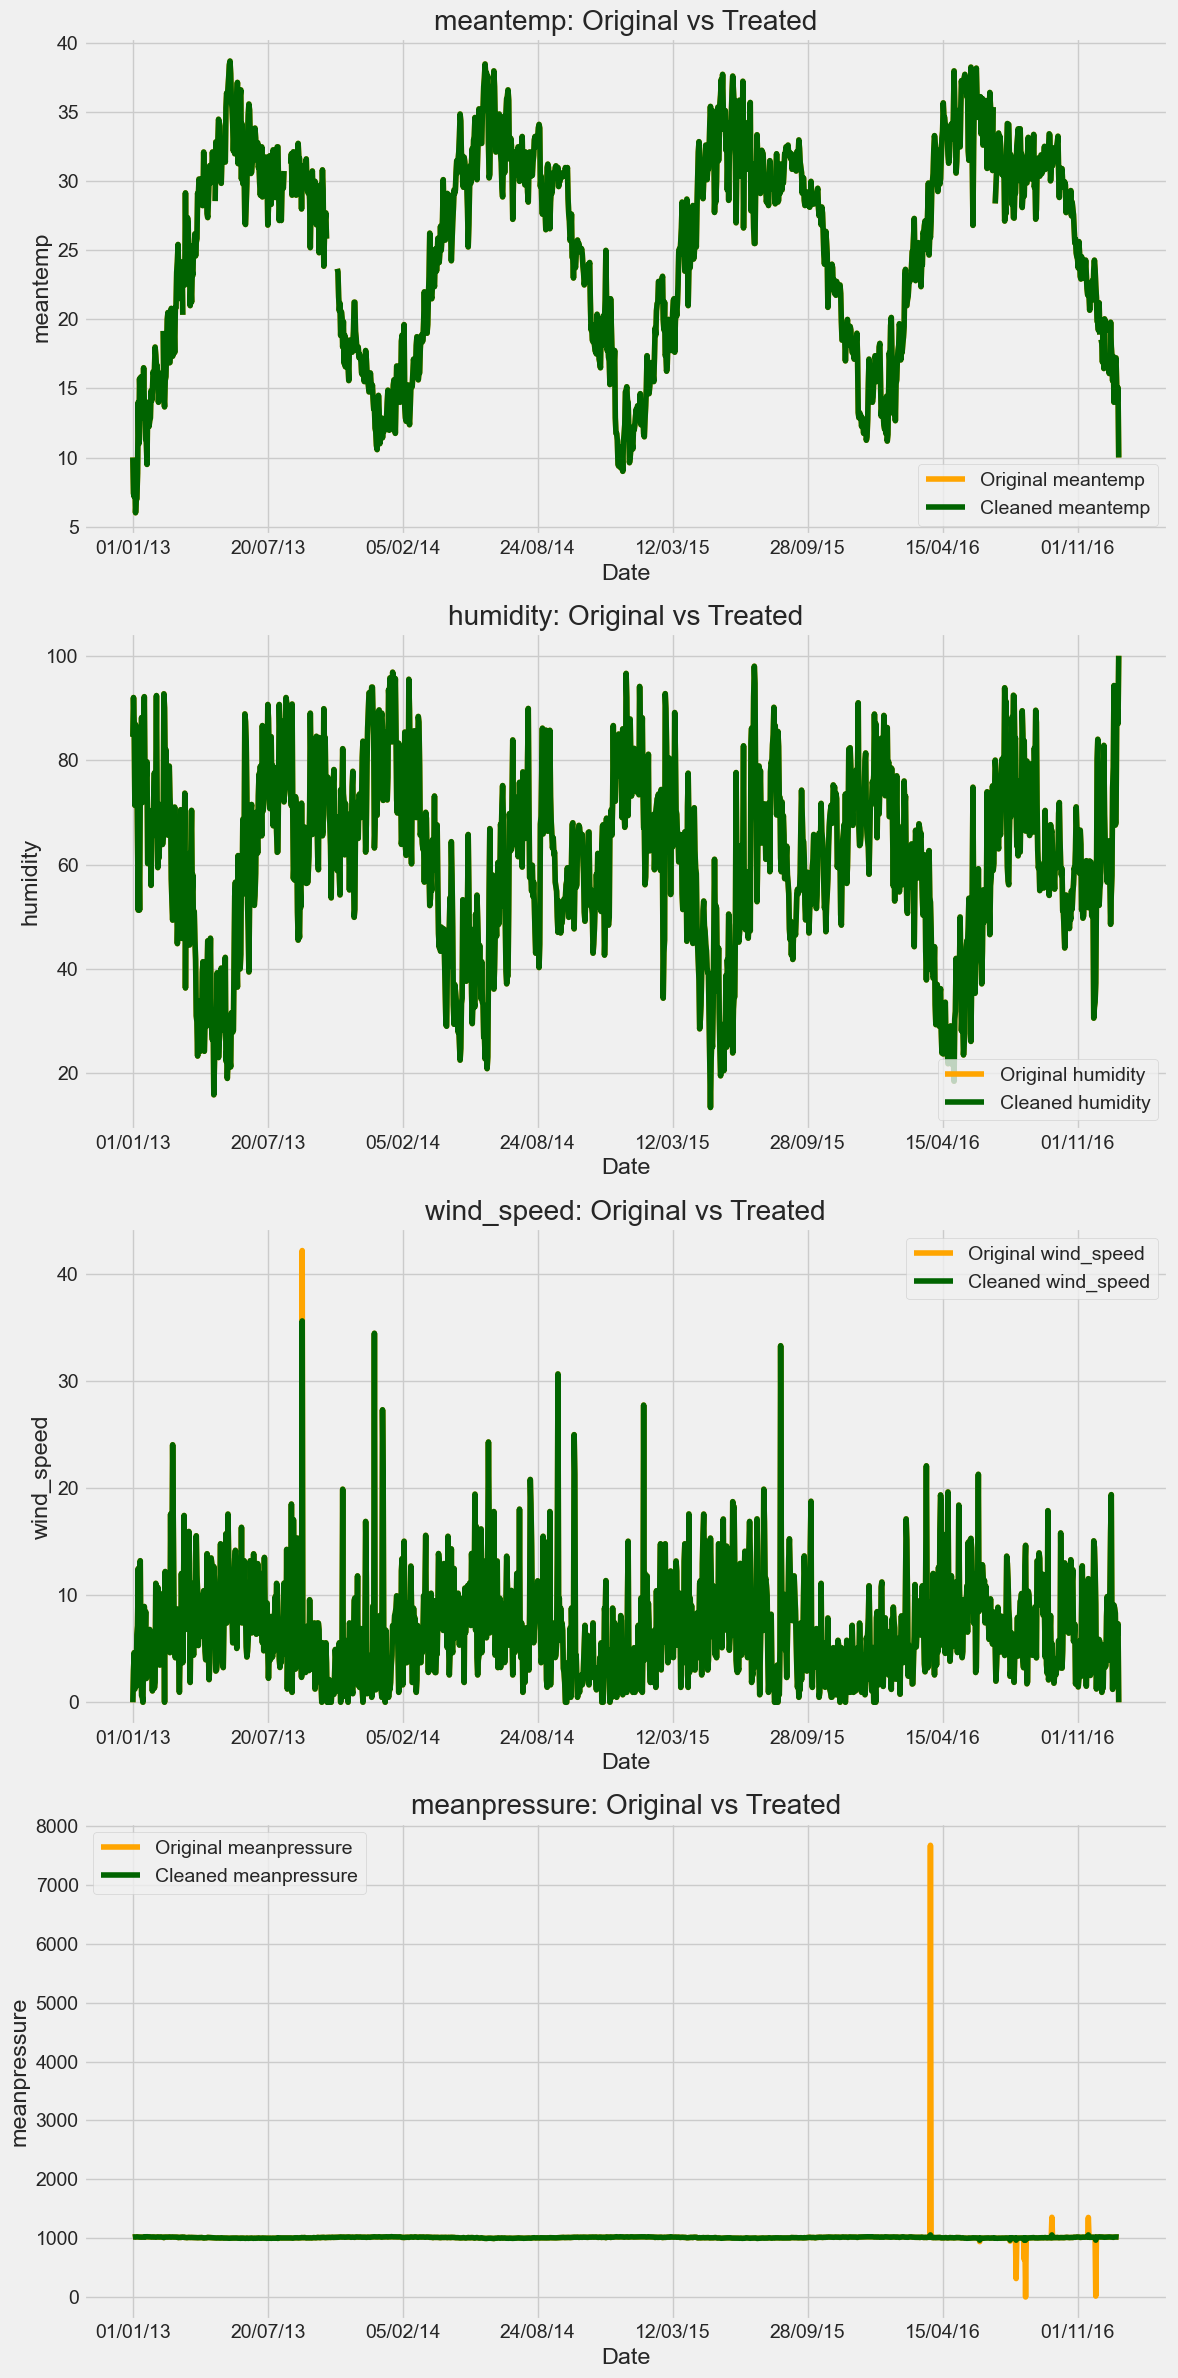

In [11]:
from matplotlib.dates import DateFormatter

def plot_line_chart(df_original, df_cleaned, columns):
    fig, axes = plt.subplots(len(columns), 1, figsize=(12, 6 * len(columns)))

    if len(columns) == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i, col in enumerate(columns):
        df_original[col].plot(ax=axes[i],label=f'Original {col}', color='orange', linestyle='-')
        df_cleaned[col].plot(ax=axes[i],label=f'Cleaned {col}', color='darkgreen', linestyle='-')
        axes[i].set_title(f'{col}: Original vs Treated')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(col)
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Plot line chart before and after treatment
plot_line_chart(df, df_cleaned, ts_vars)

In [12]:
df.index

Index(['01/01/13', '02/01/13', '03/01/13', '04/01/13', '05/01/13', '06/01/13',
       '07/01/13', '08/01/13', '09/01/13', '10/01/13',
       ...
       '23/12/16', '24/12/16', '25/12/16', '26/12/16', '27/12/16', '28/12/16',
       '29/12/16', '30/12/16', '31/12/16', '01/01/17'],
      dtype='object', name='date', length=1462)

### Time Series Decomposition:
A time series is usually composed of the following components:
   > **1) Trend :** This component usually is increasing, decreasing, or constant.  
   > **2) Seasonality :** This is the periodic behavior of the time series that occurs within a year.   
   > **3) Residual :** This is what remains of the time series after the trend and seasonality are removed.  

The basic approach to seasonal decomposition splits the time series into above components.

In [13]:
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
01/01/13,10.000000,84.500000,0.000000,1015.666667
02/01/13,7.400000,92.000000,2.980000,1017.800000
03/01/13,7.166667,87.000000,4.633333,1018.666667
04/01/13,8.666667,71.333333,1.233333,1017.166667
05/01/13,6.000000,86.833333,3.700000,1016.500000


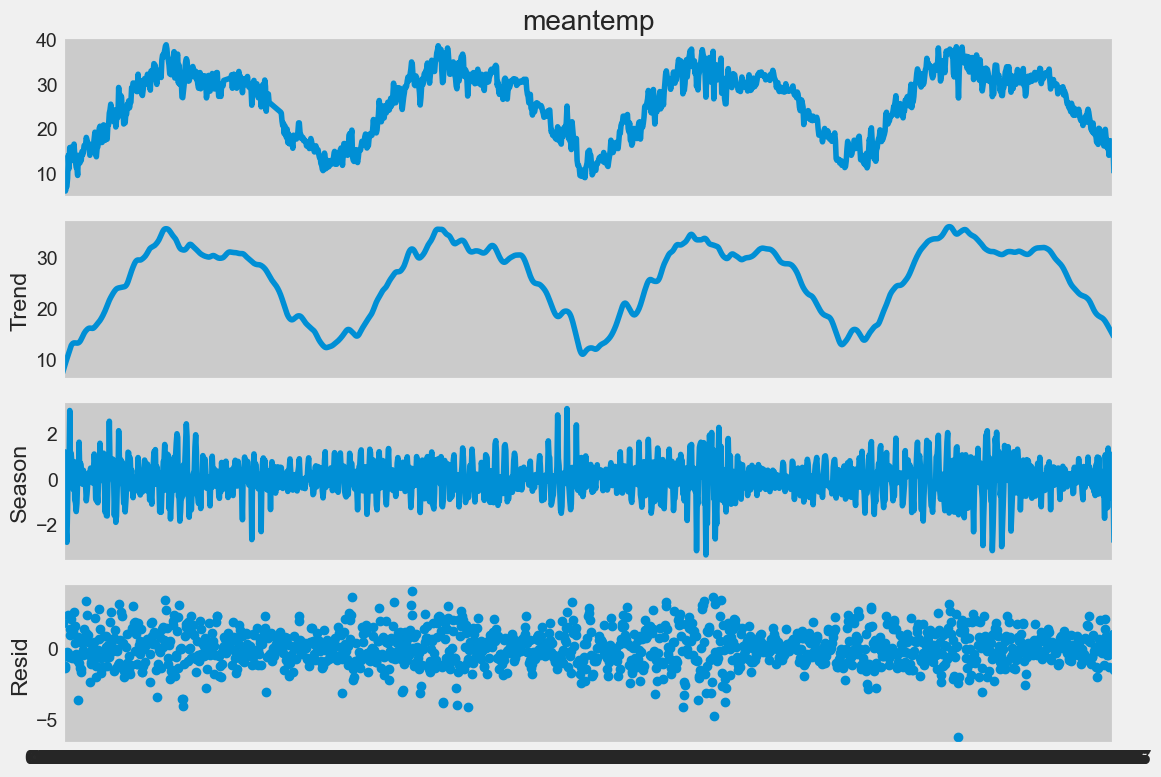

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Interpolate missing values
df['meantemp'] = df['meantemp'].interpolate(method='linear')

# Perform STL decomposition with specified period
res = STL(df['meantemp'], period=13).fit()  # Adjust period if needed

# Plot the results
res.plot()
plt.show()

In [15]:
from statsmodels.datasets import co2
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

stl_co2_data = co2.load().data
stl_co2_data = stl_co2_data.resample('ME').mean().ffill()
print(stl_co2_data.shape)
stl_co2_data.head()

(526, 1)


,co2
1958-03-31,316.100000
1958-04-30,317.200000
1958-05-31,317.433333
1958-06-30,317.433333
1958-07-31,315.625000


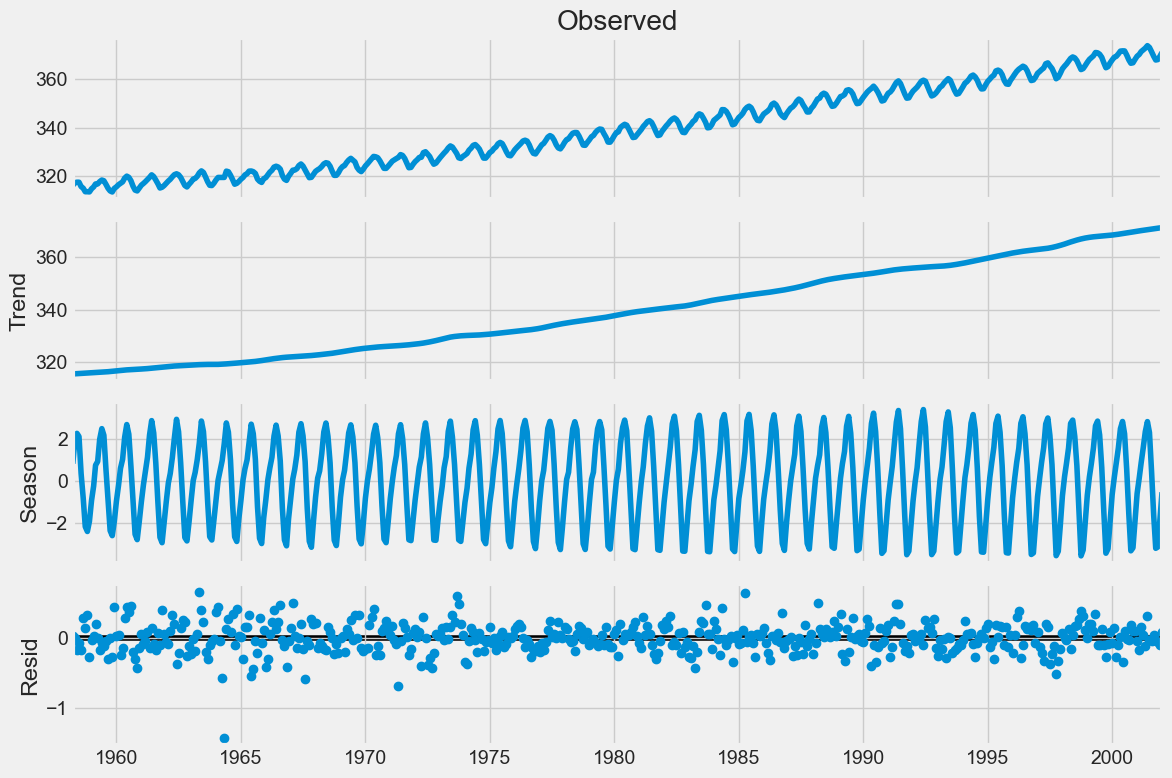

In [16]:
res = STL(stl_co2_data).fit()
res.plot()
plt.show()

**Stationary Time Series :**   
A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict

Sign of obvious trends, seasonality, or other systematic structures in the series are indicators of a non-stationary series. A more accurate method would be to use a statistical test, such as the Dickey-Fuller test.

**ADFuller Test:**  
If Test statistic < Critical Value and p-value < 0.05 – then series is stationary

In [17]:
from statsmodels.tsa.stattools import adfuller

threshold = 0.05
# Perform ADF test for each variable
for var in ts_vars:
    r = adfuller(df[var], autolag='AIC')
    output = {'Test Statistic': r[0], 'p-value': r[1], '# Lags Used': r[2], '# Observations Used': r[3]}
    # Display the results
    print(f"ADF Test Results for {var}:")
    print(output)
    if r[1] <= threshold:
        print(f'=> Series is Stationary (Reject H₀)')
    else:
        print(f'=> Series is Non-Stationary (Fail to Reject H₀)')

ADF Test Results for meantemp:
{'Test Statistic': -2.0081410135459454, 'p-value': 0.28301499622558945, '# Lags Used': 10, '# Observations Used': 1451}
=> Series is Non-Stationary (Fail to Reject H₀)
ADF Test Results for humidity:
{'Test Statistic': -3.6755769191591128, 'p-value': 0.004470100478194909, '# Lags Used': 15, '# Observations Used': 1446}
=> Series is Stationary (Reject H₀)
ADF Test Results for wind_speed:
{'Test Statistic': -3.838096756688727, 'p-value': 0.0025407221531136737, '# Lags Used': 24, '# Observations Used': 1437}
=> Series is Stationary (Reject H₀)
ADF Test Results for meanpressure:
{'Test Statistic': -38.07859002556161, 'p-value': 0.0, '# Lags Used': 0, '# Observations Used': 1461}
=> Series is Stationary (Reject H₀)


In [18]:
diff_df = df['meantemp'].diff() #first differencing for stationarity of meantemp
diff_df.dropna(inplace=True)
diff_df.head()

date
02/01/13   -2.600000
03/01/13   -0.233333
04/01/13    1.500000
05/01/13   -2.666667
06/01/13    1.000000
Name: meantemp, dtype: float64

In [19]:
# Perform ADF test for meantemp post differencing
threshold = 0.05
r = adfuller(diff_df, autolag='AIC')
output = {'Test Statistic': r[0], 'p-value': r[1], '# Lags Used': r[2], '# Observations Used': r[3]}
# Display the results
print(f"ADF Test Results for meantemp variable post first differencing:")
print(output)
if r[1] <= threshold:
    print(f'=> Series is Stationary (Reject H₀)')
else:
    print(f'=> Series is Non-Stationary (Fail to Reject H₀)')

ADF Test Results for meantemp variable post first differencing:
{'Test Statistic': -16.46919301330268, 'p-value': 2.2915861097038134e-29, '# Lags Used': 9, '# Observations Used': 1451}
=> Series is Stationary (Reject H₀)


In [20]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.517715,60.771702,6.802209,1011.104548
std,7.352290,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.875000,62.625000,6.221667,1008.563492
75%,31.285714,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


### Autocorrelation Check : ACF and PACF

- **ACF (Autocorrelation Function)** helps identify moving average (MA) processes and indicates how much past values contribute to the current observation.
  
- **PACF (Partial Autocorrelation Function)** is used to identify autoregressive (AR) processes by showing the direct contribution of past values to the current observation, removing the effects of intermediary lags.

- **Interpretation:**
  - An exponential decay in ACF plot with sharp cut-off in PACF at lag p suggests an **AR (p) (Autoregressive) model**.
  - An exponential decay in PACF plot with significant spike at lag q in ACF plot suggests an **MA (q) (Moving Average) model**.

- **Model Selection:**
  - A combination of patterns from ACF and PACF can help identify the right model for your time series:
    - **AR model**: Sharp cut-off in PACF.
    - **MA model**: Sharp cut-off in ACF.
    - **ARMA/ARIMA models**: Mixed behavior of ACF and PACF.

These insights guide you in selecting the appropriate model for forecasting, whether it's AR, MA, ARMA, or ARIMA.

<Figure size 1200x600 with 0 Axes>

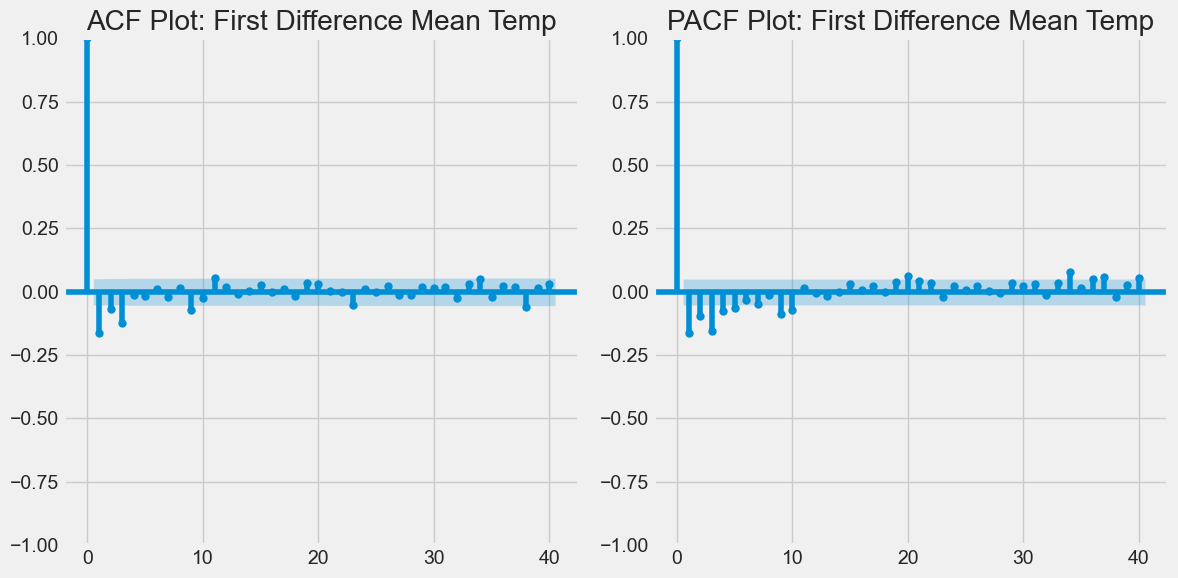

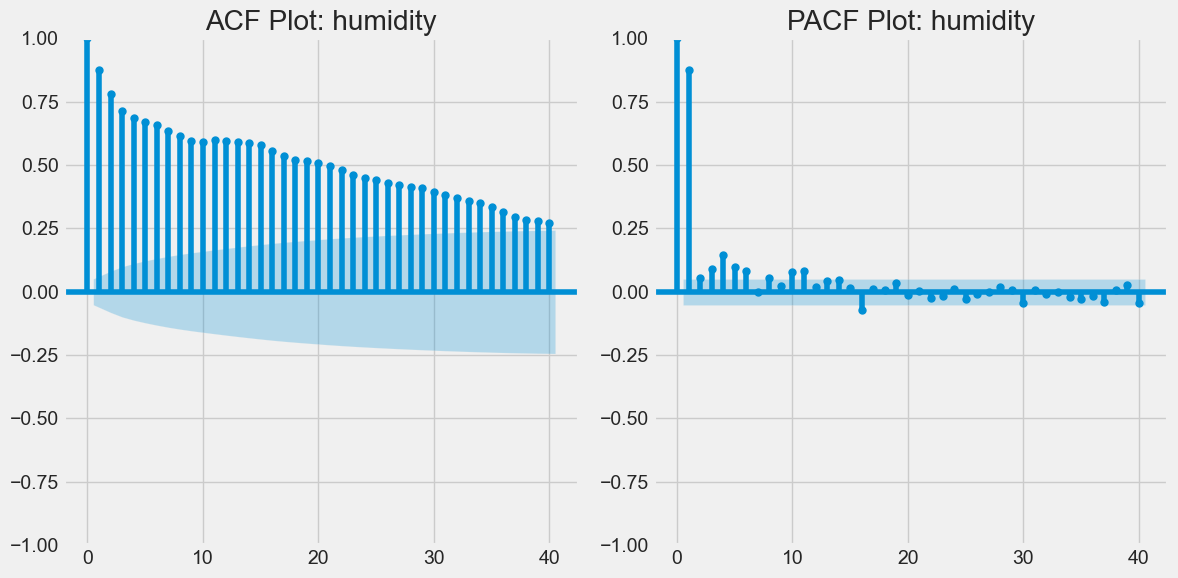

In [21]:
# Auto-Correlation Check : ACF & PACF Plots
# Create ACF and PACF plots
plt.figure(figsize=(12, 6))

# Create ACF and PACF plots for each variable
for var in ts_vars[:2]:
    plt.figure(figsize=(12, 6))

    if var == 'meantemp':
        target = diff_df
        var = "First Difference Mean Temp"
    else:
        target = df[var]

    # Autocorrelation Function (ACF) Plot
    plt.subplot(121)
    plot_acf(target, lags=40, ax=plt.gca())  # Drop any NaN values and plot ACF up to 40 lags
    plt.title(f'ACF Plot: {var}')

    # Partial Autocorrelation Function (PACF) Plot
    plt.subplot(122)
    plot_pacf(target, lags=40, ax=plt.gca())  # Drop NaN values and plot PACF up to 40 lags
    plt.title(f'PACF Plot: {var}')

    plt.tight_layout()
    plt.show()

<div style="color:white;
           display:fill;
           background-color:black;
           padding: 10px;
           font-family:Verdana;
           letter-spacing:0.5px">
    <h3 style="color:white;padding-left:20px"><b>Observation </b></h3>
       <p style="color:white;font-size:110%;padding-left:50px">
       Mean Temperature (First Difference) <br>
           1.First Difference to make it stationary (d=1) <br>
           2.From ACF plot we can see that MA(q=4) <br>
           3.From PACF plot we can see that AR(p=11) <br>
       Humidity <br>
           1.From ACF plot we can see that MA(0) values can be 0 since exponential decay <br>
           2.From PACF plot we can see that AR(p) values can be 7, 12 & 17 <br>
         </p>
         </p>
         
</div>

### Feature Engineering (Optional)

In [22]:
import pandas as pd
import numpy as np

# Convert date index to datetime
df.index = pd.to_datetime(df.index, format='%d/%m/%y')

# 1. Date-based features
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # 5 and 6 are Saturday and Sunday

# 2. Rolling statistics
df['temp_7d_rolling_mean'] = df['meantemp'].rolling(window=7).mean()
df['temp_30d_rolling_mean'] = df['meantemp'].rolling(window=30).mean()
df['humidity_7d_rolling_std'] = df['humidity'].rolling(window=7).std()

# 3. Lag features
df['temp_lag_1'] = df['meantemp'].shift(1)
df['humidity_lag_1'] = df['humidity'].shift(1)

# 4. Interaction Features
# Wind chill index approximation (for temperatures in Celsius)
df['wind_chill'] = 13.12 + 0.6215 * df['meantemp'] - 11.37 * (df['wind_speed']**0.16) + 0.3965 * df['meantemp'] * (df['wind_speed']**0.16)

# Dew point approximation formula
df['dew_point'] = df['meantemp'] - ((100 - df['humidity']) / 5)

# 5. Categorical binning
df['temp_category'] = pd.cut(df['meantemp'], bins=[-np.inf, 5, 15, np.inf], labels=['Cold', 'Moderate', 'Hot'])
df['humidity_category'] = pd.cut(df['humidity'], bins=[-np.inf, 60, 80, np.inf], labels=['Low', 'Medium', 'High'])

# 6. Differencing
df['temp_diff'] = df['meantemp'].diff()
df['humidity_diff'] = df['humidity'].diff()

# Display updated DataFrame with new features
df.head()


,meantemp,humidity,wind_speed,meanpressure,day,month,year,day_of_week,is_weekend,temp_7d_rolling_mean,temp_30d_rolling_mean,humidity_7d_rolling_std,temp_lag_1,humidity_lag_1,wind_chill,dew_point,temp_category,humidity_category,temp_diff,humidity_diff
date,,,,,,,,,,,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,1,2013,1,0,NaN,NaN,NaN,NaN,NaN,19.335000,6.900000,Moderate,High,NaN,NaN
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2,1,2013,2,0,NaN,NaN,NaN,10.000000,84.500000,7.672803,5.800000,Moderate,High,-2.600000,7.500000
2013-01-03,7.166667,87.000000,4.633333,1018.666667,3,1,2013,3,0,NaN,NaN,NaN,7.400000,92.000000,6.674463,4.566667,Moderate,High,-0.233333,-5.000000
2013-01-04,8.666667,71.333333,1.233333,1017.166667,4,1,2013,4,0,NaN,NaN,NaN,7.166667,87.000000,10.301933,2.933333,Moderate,Medium,1.500000,-15.666667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,5,1,2013,5,1,NaN,NaN,NaN,8.666667,71.333333,5.764394,3.366667,Moderate,High,-2.666667,15.500000


In [23]:
# Backward Fill for missing values due to dates not present
df = df.bfill()
df.head()

,meantemp,humidity,wind_speed,meanpressure,day,month,year,day_of_week,is_weekend,temp_7d_rolling_mean,temp_30d_rolling_mean,humidity_7d_rolling_std,temp_lag_1,humidity_lag_1,wind_chill,dew_point,temp_category,humidity_category,temp_diff,humidity_diff
date,,,,,,,,,,,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,1,2013,1,0,7.604762,11.937262,6.693845,10.000000,84.500000,19.335000,6.900000,Moderate,High,-2.600000,7.500000
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2,1,2013,2,0,7.604762,11.937262,6.693845,10.000000,84.500000,7.672803,5.800000,Moderate,High,-2.600000,7.500000
2013-01-03,7.166667,87.000000,4.633333,1018.666667,3,1,2013,3,0,7.604762,11.937262,6.693845,7.400000,92.000000,6.674463,4.566667,Moderate,High,-0.233333,-5.000000
2013-01-04,8.666667,71.333333,1.233333,1017.166667,4,1,2013,4,0,7.604762,11.937262,6.693845,7.166667,87.000000,10.301933,2.933333,Moderate,Medium,1.500000,-15.666667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,5,1,2013,5,1,7.604762,11.937262,6.693845,8.666667,71.333333,5.764394,3.366667,Moderate,High,-2.666667,15.500000


## <p style='color:white;font-size:1%;'>Time Series Forecasting : Modelling</p>
<h2 style="background-color:black;font-family:verdana;color:white;font-size:200%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px"> TIME SERIES FORECASTING : MODELLING </h2> 

### Train-Test Split

Train Data Range: 2013-01-01 00:00:00 to 2015-12-31 00:00:00
Test Data Range: 2016-01-01 00:00:00 to 2017-01-01 00:00:00


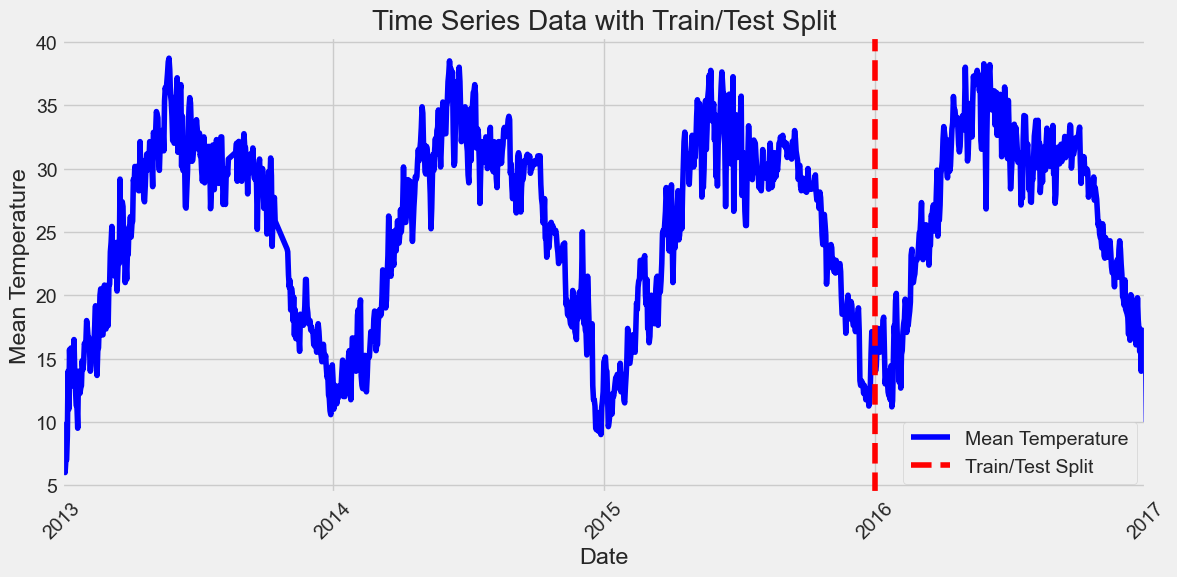

In [24]:
train_df = df.loc[df.index<'2016-01-01']
test_df = df.loc[df.index>='2016-01-01']

# Display Train and Test date ranges
train_start, train_end = train_df.index.min(), train_df.index.max()
test_start, test_end = test_df.index.min(), test_df.index.max()

print(f"Train Data Range: {train_start} to {train_end}")
print(f"Test Data Range: {test_start} to {test_end}")

# Create a line plot for the entire dataset
plt.figure(figsize=(12, 6))
df['meantemp'].plot(label='Mean Temperature', color='blue', linestyle='-')

# Add vertical line for the split date
plt.axvline(x=pd.to_datetime('2016-01-01'), color='red', linestyle='--', label='Train/Test Split')

# Set title and labels
plt.title('Time Series Data with Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()

# Improve x-axis formatting
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Exponential Smoothing:**  
Exponential smoothing is a time series forecasting method for univariate data. There are three main types of exponential smoothing time series forecasting methods.
A simple method that assumes no systematic structure, an extension that explicitly handles trends, and the most advanced approach that add support for seasonality.

## <p style='color:white;font-size:1%;'>Arima</p>
<h2 style="background-color:black;font-family:verdana;color:white;font-size:200%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px"> ARIMA </h2> 

A popular and widely used statistical method for time series forecasting is the ARIMA model. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. The parameters of the ARIMA model are defined as follows:

>**p** : The number of lag observations included in the model, also called the lag order.   
>**d** : The number of times that the raw observations are differenced, also called the degree of differencing.   
>**q** : The size of the moving average window, also called the order of moving average.

In [25]:
# we got the p,d,q value from time series analysis
arima = ARIMA(train_df['meantemp'], order=(11,1,4)).fit()
ar_train_pred = arima.fittedvalues
ar_test_pred = arima.forecast(len(test_df.index))

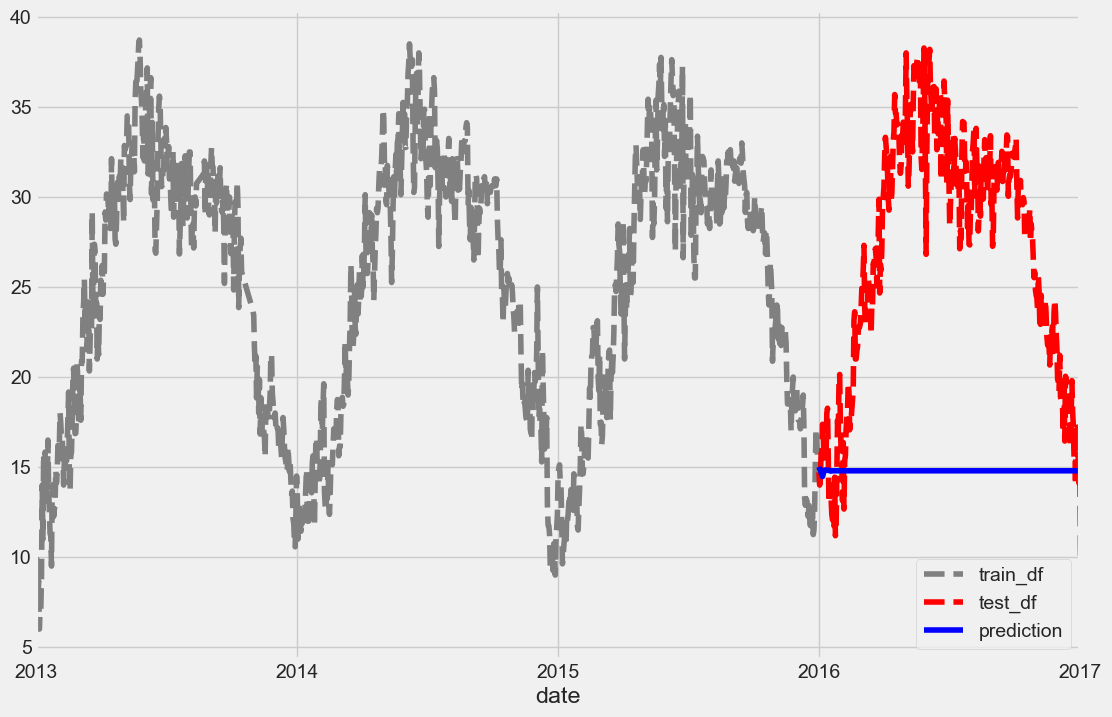

In [26]:
train_df['meantemp'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['meantemp'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [27]:
print('Train RMSE:',mean_squared_error(train_df['meantemp'], ar_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['meantemp'], ar_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['meantemp'], ar_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['meantemp'], ar_test_pred))

Train RMSE: 1.6170923638229473
Test RMSE: 14.072268319310043
Train MAPE: 0.05402756710068854
Test MAPE: 0.42021279179411447


In [28]:
# we got the p,d,q value from time series analysis
ar = ARIMA(train_df['humidity'], order=(7,0,1)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(len(test_df.index))

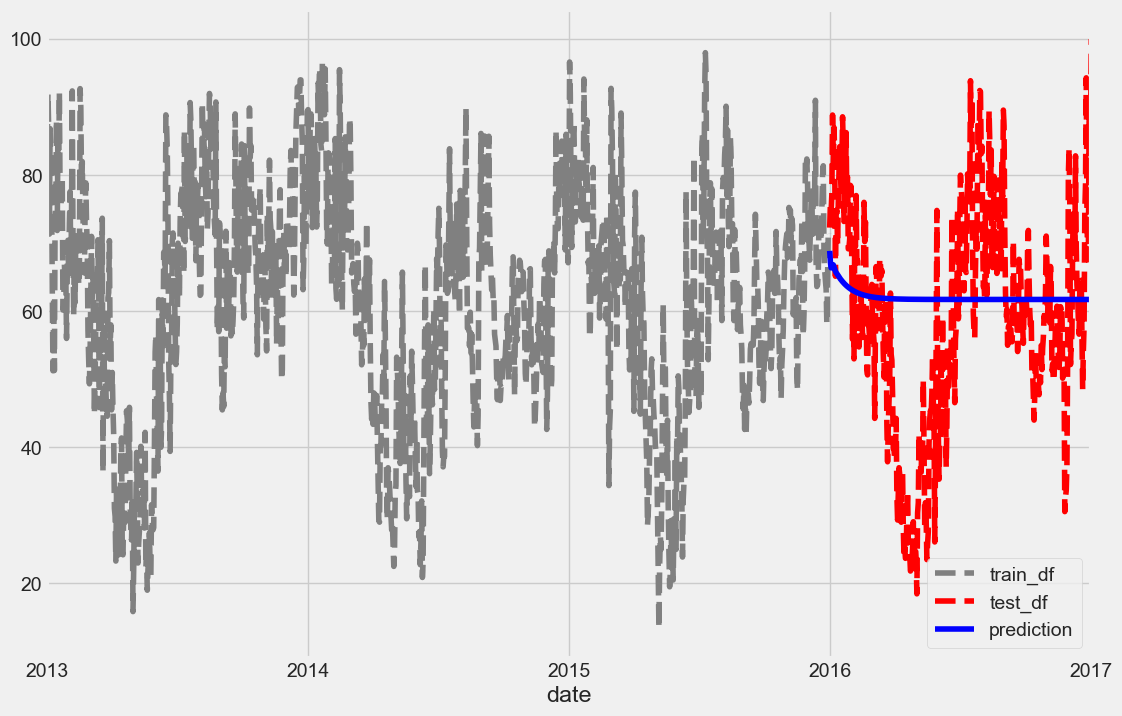

In [29]:
train_df['humidity'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['humidity'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [30]:
print('Train RMSE:',mean_squared_error(train_df['humidity'], ar_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['humidity'], ar_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['humidity'], ar_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['humidity'], ar_test_pred))

Train RMSE: 8.002898016150159
Test RMSE: 16.626586129253997
Train MAPE: 0.10859682115703587
Test MAPE: 0.2956619899481987


## <p style='color:white;font-size:1%;'>Grid Search p,d,q Values</p>
<h2 style="background-color:black;font-family:verdana;color:white;font-size:200%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px"> Grid Search p,d,q Values </h2>

From acf and pacf we got different potenstial p,q values. Lets use grid search to find the best pair out of them

In [31]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(arima_order,col):
    # prepare training dataset
    train_df = df.loc[df.index<'2016-01-01']
    test_df = df.loc[df.index>='2016-01-01']
    # make predictions
    model = ARIMA(train_df[col], order=arima_order).fit()
    model_pred = model.forecast(len(test_df.index))
    rmse = (mean_squared_error(test_df[col], model_pred)**0.5)
    return rmse

In [32]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, q_values, col):
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for q in q_values:
				order = (p,1,q)
				try:
					rmse = evaluate_arima_model(order, col)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [33]:
# evaluate parameters
p_values = [7,10,12]
q_values = [0,10]

evaluate_models(p_values, q_values, 'meantemp')

Best ARIMA(7, 1, 0) RMSE=13.796


In [34]:
arima = ARIMA(train_df['meantemp'], order=(7,1,0)).fit()
arima_train_pred = arima.predict()
arima_test_pred = arima.forecast(len(test_df.index))

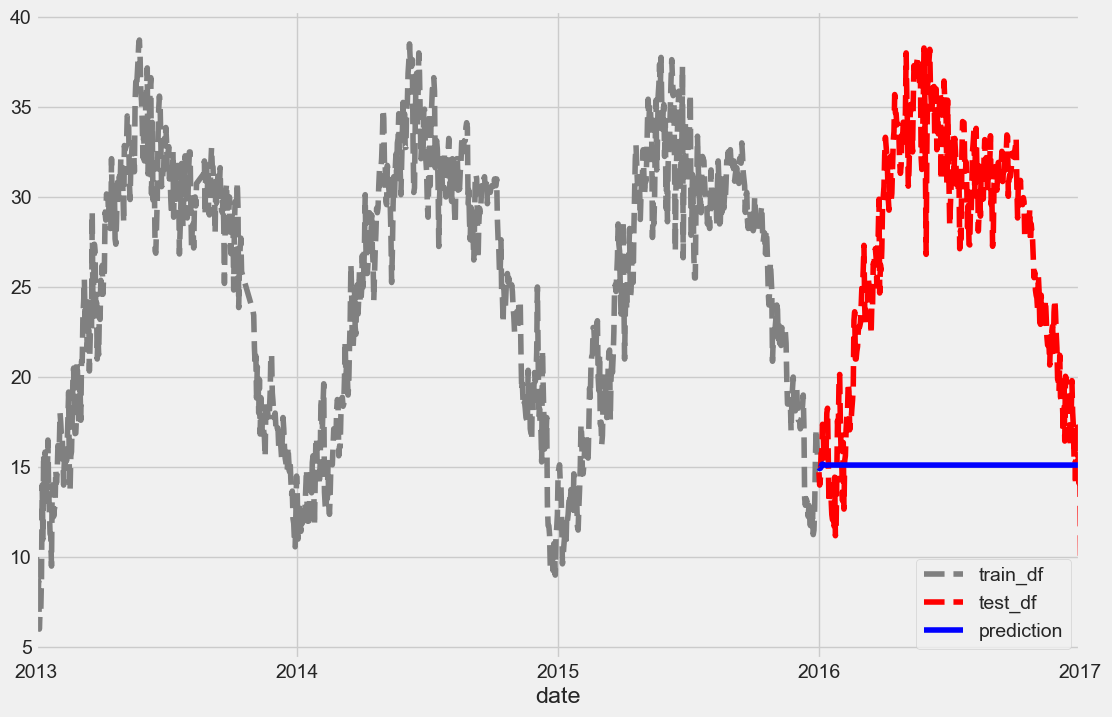

In [35]:
train_df['meantemp'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['meantemp'].plot(style='--', color='r', legend=True, label='test_df')
arima_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [36]:
print('Train RMSE:',mean_squared_error(train_df['meantemp'], arima_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['meantemp'], arima_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['meantemp'], arima_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['meantemp'], arima_test_pred))

Train RMSE: 1.6283313295758153
Test RMSE: 13.796319221835194
Train MAPE: 0.05393361041769318
Test MAPE: 0.4098558144420534


## <p style='color:white;font-size:1%;'>Auto Arima</p>
<h2 style="background-color:black;font-family:verdana;color:white;font-size:200%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px"> Auto ARIMA </h2>
Although ARIMA is a very powerful model for forecasting time series data, the data preparation and parameter tuning processes end up being really time consuming. Before implementing ARIMA, you need to make the series stationary, and determine the values of p and q using the plots we discussed above. Auto ARIMA makes this task really simple for us as it eliminates many steps

In [37]:
auto_arima(df['meantemp'],m=12, max_order= None, max_p=12, max_q=12, max_d=1,max_P=12, max_Q=12, max_D=1, maxiter=50, alpha=0.05, n_jobs=-1,information_criterion='aic', out_of_sample_size=30).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1462
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2752.448
Date:                            Tue, 01 Oct 2024   AIC                           5518.895
Time:                                    16:38:52   BIC                           5555.903
Sample:                                         0   HQIC                          5532.700
                                           - 1462                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5451      0.056      9.736      0.000       0.435       0.655
ar.L2          0.0078      0.027      0.285      0.776      -0.046       0.062
ar.L3         -0.0613      0.030     -2.036      0.042      -0.120      -0.002
ma.L1         -0.7702      0.053    -14.641      0.000      -0.873      -0.667
ar.S.L12       0.7268      0.230      3.160      0.002       0.276       1.178
ma.S.L12      -0.6882      0.240     -2.873      0.004      -1.158      -0.219
sigma2         2.5317      0.071     35.597      0.000       2.392       2.671
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               270.22
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.49
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
# pass the order and seasonal order values we got from auto arima
sarima = SARIMAX(train_df['meantemp'], order=(3,1,1), seasonal_order=(1,0,1,12)).fit()
sarima_train_pred = sarima.predict()
sarima_test_pred = sarima.forecast(len(test_df.index))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89168D+00    |proj g|=  9.90212D-03

At iterate    5    f=  1.89104D+00    |proj g|=  2.03258D-02

At iterate   10    f=  1.88751D+00    |proj g|=  7.05085D-03

At iterate   15    f=  1.88743D+00    |proj g|=  1.29168D-04

At iterate   20    f=  1.88740D+00    |proj g|=  8.63547D-03

At iterate   25    f=  1.88651D+00    |proj g|=  7.48923D-03

At iterate   30    f=  1.88634D+00    |proj g|=  6.37804D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

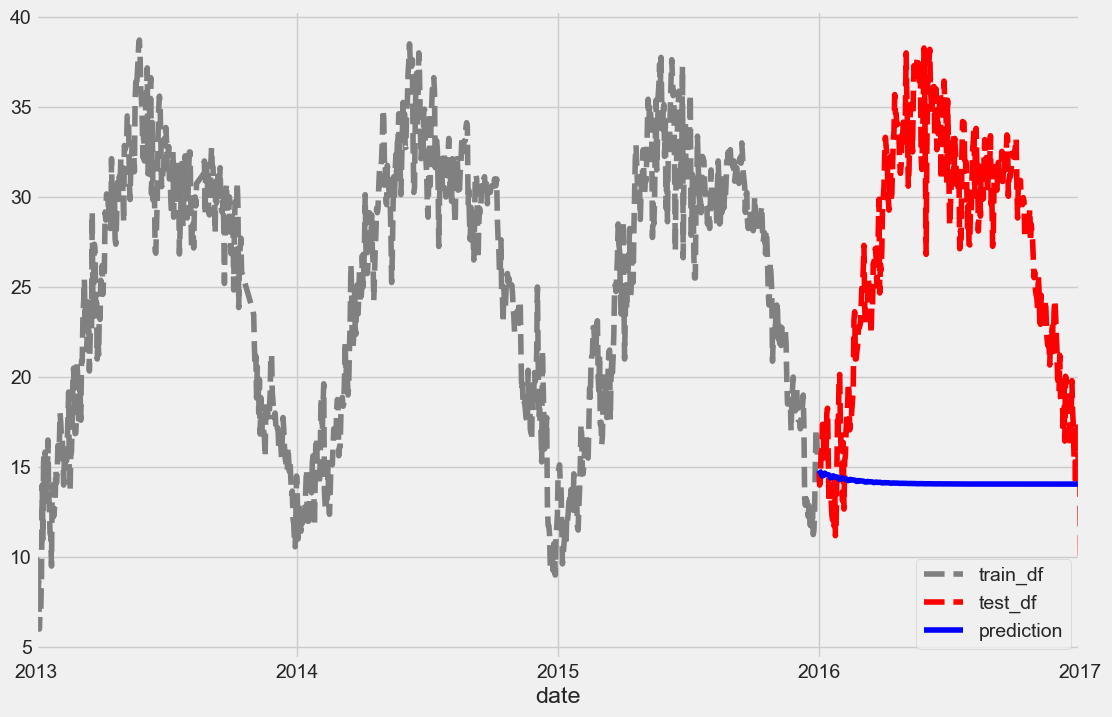

In [39]:
train_df['meantemp'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['meantemp'].plot(style='--', color='r', legend=True, label='test_df')
sarima_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [40]:
print('Train RMSE:',mean_squared_error(train_df['meantemp'], sarima_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['meantemp'], sarima_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['meantemp'], sarima_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['meantemp'], sarima_test_pred))

Train RMSE: 1.6263083921013783
Test RMSE: 14.693651367181864
Train MAPE: 0.05427730851166229
Test MAPE: 0.4424488117619034


## <p style='color:white;font-size:1%;'>Single Exponential Smoothing</p>
<h2 style="background-color:black;font-family:verdana;color:white;font-size:200%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px"> Single Exponential Smoothing </h2> 
  
Single Exponential Smoothing, SES for short, also called Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality.

In [41]:
single_exp = SimpleExpSmoothing(train_df['meantemp']).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(len(test_df.index))

<Axes: xlabel='date'>

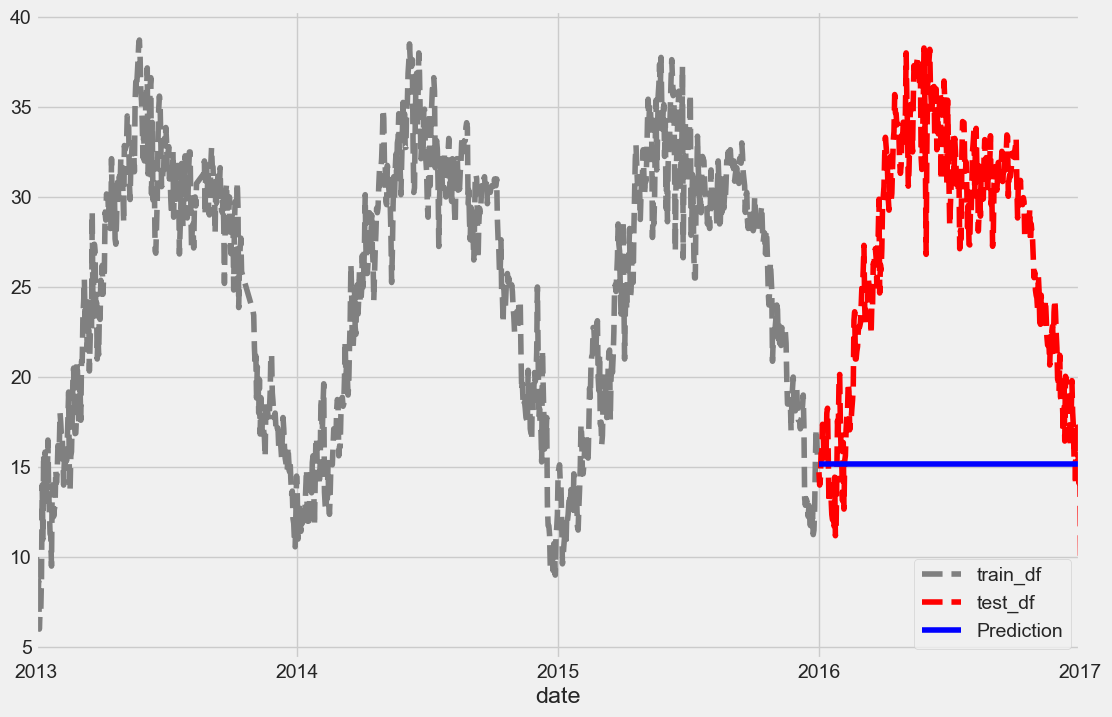

In [42]:
train_df['meantemp'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['meantemp'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [43]:
print('Train RMSE:',mean_squared_error(train_df['meantemp'], single_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['meantemp'], single_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['meantemp'], single_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['meantemp'], single_exp_test_pred))

Train RMSE: 1.628923848557618
Test RMSE: 13.751483952573757
Train MAPE: 0.05348991722491709
Test MAPE: 0.4083235869916041


In [44]:
single_exp = SimpleExpSmoothing(train_df['humidity']).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(len(test_df.index))

<Axes: xlabel='date'>

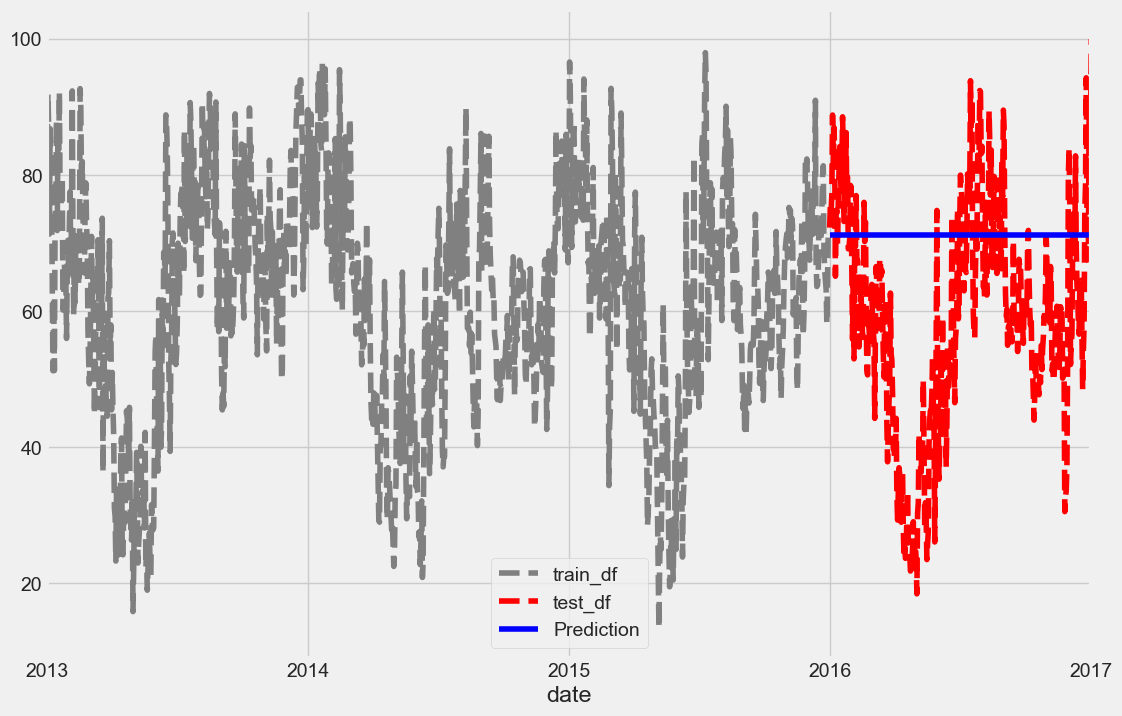

In [45]:
train_df['humidity'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['humidity'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [46]:
print('Train RMSE:',mean_squared_error(train_df['humidity'], single_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['humidity'], single_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['humidity'], single_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['humidity'], single_exp_test_pred))

Train RMSE: 8.345928383267916
Test RMSE: 20.673233432368125
Train MAPE: 0.11008302968951056
Test MAPE: 0.39588445806687345


## <p style='color:white;font-size:1%;'>Double Exponential Smoothing</p>
<h2 style="background-color:black;font-family:verdana;color:white;font-size:200%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px"> Double Exponential Smoothing </h2> 
   
Double Exponential Smoothing is an extension to Exponential Smoothing that explicitly adds support for trends in the univariate time series

In [47]:
double_exp = ExponentialSmoothing(train_df['meantemp'], trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=365, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(len(test_df.index))

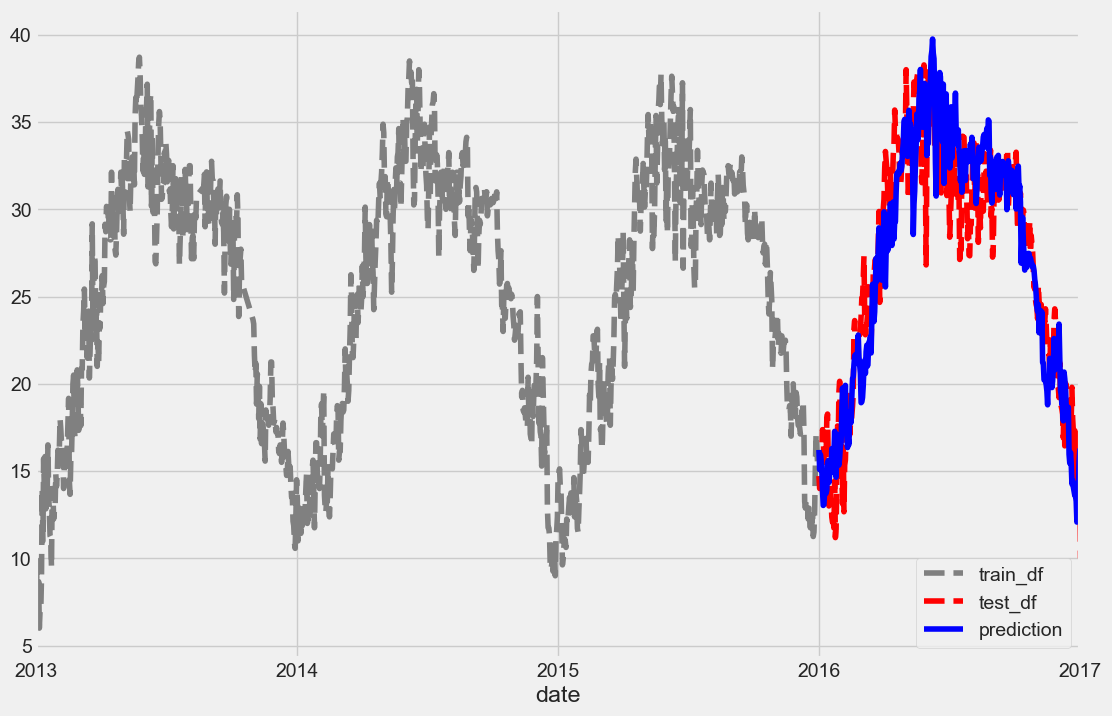

In [48]:
train_df['meantemp'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['meantemp'].plot(style='--', color='r', legend=True, label='test_df')
double_exp_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [49]:
print('Train RMSE:',mean_squared_error(train_df['meantemp'], double_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['meantemp'], double_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['meantemp'], double_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['meantemp'], double_exp_test_pred))

Train RMSE: 1.4612911283803138
Test RMSE: 2.7262885488501976
Train MAPE: 0.04761198359927406
Test MAPE: 0.08791676637092109


In [50]:
double_exp = ExponentialSmoothing(train_df['humidity'], trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=365, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(len(test_df.index))

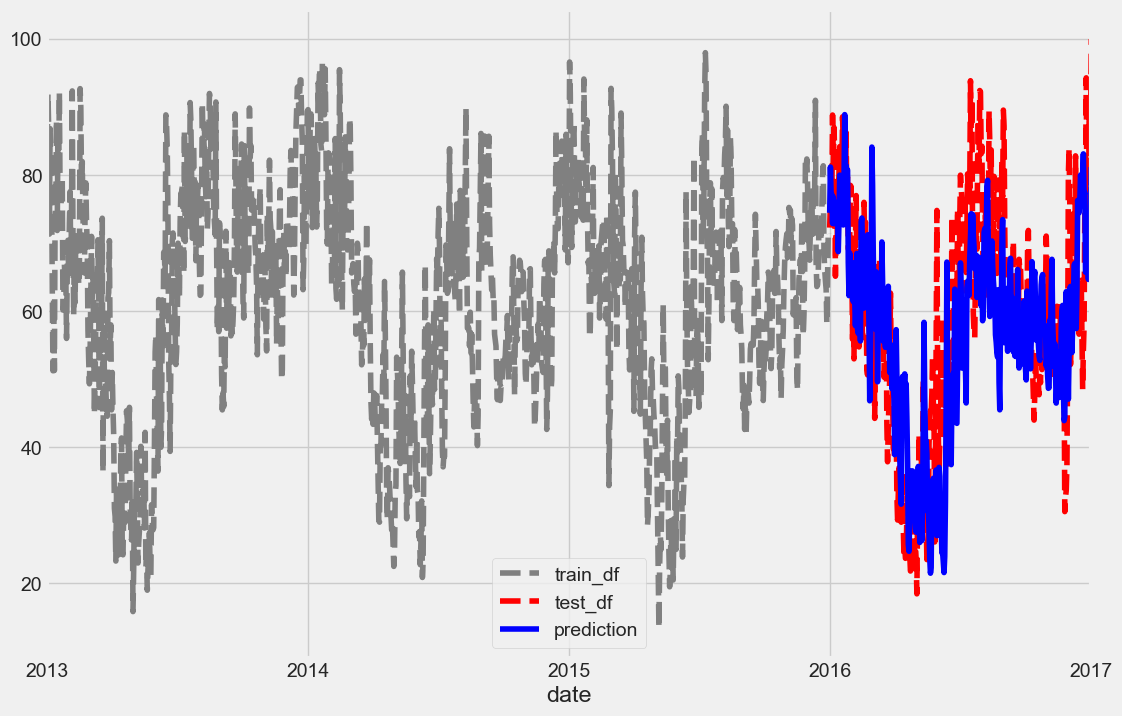

In [51]:
train_df['humidity'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['humidity'].plot(style='--', color='r', legend=True, label='test_df')
double_exp_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [52]:
print('Train RMSE:',mean_squared_error(train_df['humidity'], double_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['humidity'], double_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['humidity'], double_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['humidity'], double_exp_test_pred))

Train RMSE: 7.547741363486751
Test RMSE: 13.177930553363414
Train MAPE: 0.10023996361945393
Test MAPE: 0.20066695164383058


## <p style='color:white;font-size:1%;'>Triple Exponential Smoothing</p>
<h2 style="background-color:black;font-family:verdana;color:white;font-size:200%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px"> Triple Exponential Smoothing </h2> 
Triple Exponential Smoothing is an extension of Exponential Smoothing that explicitly adds support for seasonality to the univariate time series. Also known as Holt-Winters Exponential Smoothing.

In [53]:
hw_model = ExponentialSmoothing(train_df['meantemp'],
                          trend    ='add',
                          initialization_method='heuristic',
                          seasonal = "add", 
                          seasonal_periods=365, 
                          damped_trend=True).fit()
hw_train_pred =  hw_model.fittedvalues
hw_test_pred =  hw_model.forecast(len(test_df.index))

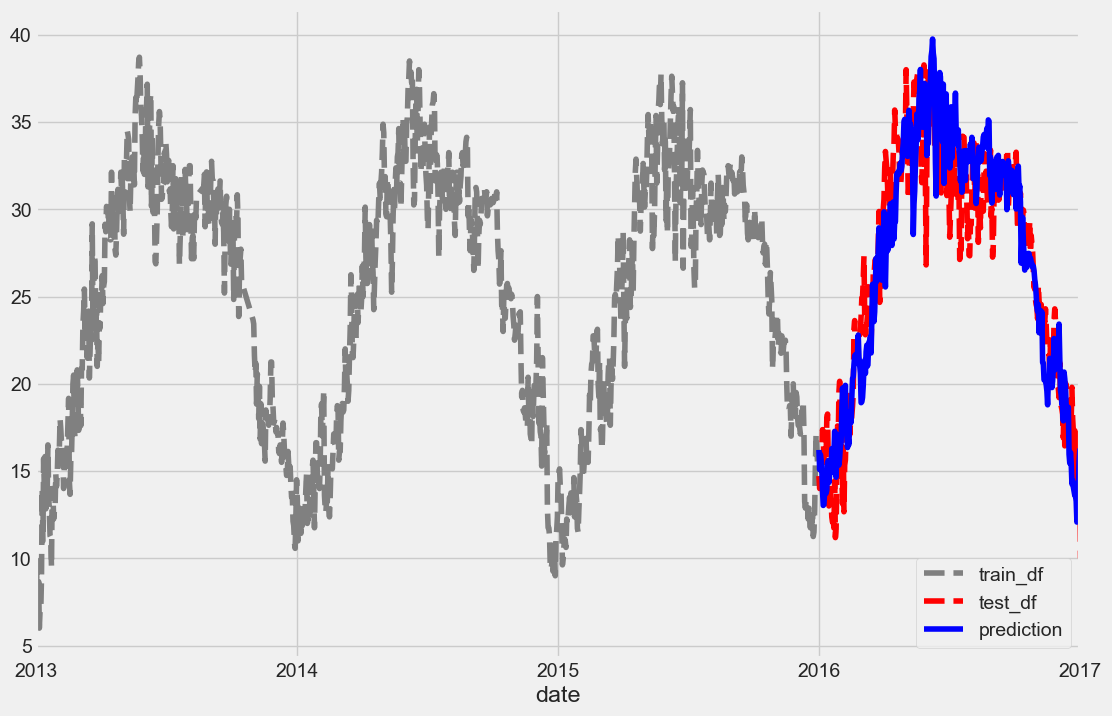

In [54]:
train_df['meantemp'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['meantemp'].plot(style='--', color='r', legend=True, label='test_df')
hw_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [55]:
print('Train RMSE:',mean_squared_error(train_df['meantemp'], hw_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['meantemp'], hw_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['meantemp'], hw_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['meantemp'], hw_test_pred))

Train RMSE: 1.4612841123273392
Test RMSE: 2.726284639198764
Train MAPE: 0.04761260062061137
Test MAPE: 0.08791694272983526


In [56]:
hw_model = ExponentialSmoothing(train_df['humidity'],
                          trend    ='add',
                          initialization_method='heuristic',
                          seasonal = "add", 
                          seasonal_periods=365, 
                          damped_trend=True).fit()
hw_train_pred =  hw_model.fittedvalues
hw_test_pred =  hw_model.forecast(len(test_df.index))

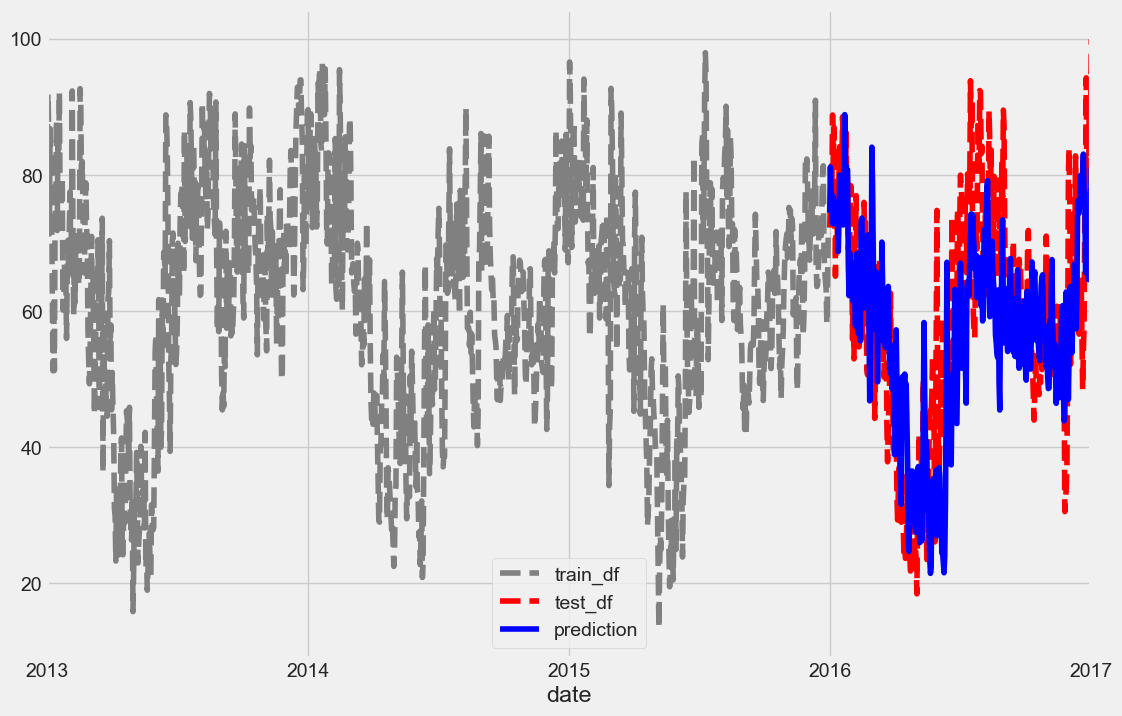

In [57]:
train_df['humidity'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['humidity'].plot(style='--', color='r', legend=True, label='test_df')
hw_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [58]:
print('Train RMSE:',mean_squared_error(train_df['humidity'], hw_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['humidity'], hw_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['humidity'], hw_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['humidity'], hw_test_pred))

Train RMSE: 7.548407044461304
Test RMSE: 13.183769254867817
Train MAPE: 0.10031209587463141
Test MAPE: 0.20065492004369365


## <p style='color:white;font-size:1%;'>Prophet</p>
<h2 style="background-color:black;font-family:verdana;color:white;font-size:200%;text-align:center;border-radius:10px 10px;letter-spacing:0.5px;padding: 10px"> Prophet </h2>

The Prophet library is an open-source library designed for making forecasts for univariate time series datasets. It is easy to use and designed to automatically find a good set of hyperparameters for the model in an effort to make skillful forecasts for data with trends and seasonal structure by default.

The DataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the date-times. The second column must have the name ‘y‘ and contain the observations.

In [59]:
# converting the original dataframe into required format by prophet
prophet_df = pd.DataFrame(df['meantemp'].copy())
prophet_df.reset_index(inplace=True)
prophet_df.columns=['ds','y']
prophet_df.head()

,ds,y
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000


In [60]:
# train test split data
prophet_train_df = prophet_df.loc[prophet_df.ds<'2016-01-01']
prophet_test_df = prophet_df.loc[prophet_df.ds>='2016-01-01']
train_start, train_end = prophet_train_df.ds.min(), prophet_train_df.ds.max()
test_start, test_end = prophet_test_df.ds.min(), prophet_test_df.ds.max()

print(f"Train Data Range: {train_start} to {train_end}")
print(f"Test Data Range: {test_start} to {test_end}")

Train Data Range: 2013-01-01 00:00:00 to 2015-12-31 00:00:00
Test Data Range: 2016-01-01 00:00:00 to 2017-01-01 00:00:00


In [61]:
prophet_model = Prophet()
prophet_model.fit(prophet_train_df) #fit training data to model

16:38:58 - cmdstanpy - INFO - Chain [1] start processing
16:38:58 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
future = prophet_model.make_future_dataframe(periods=len(prophet_test_df.ds), freq='d')
prophet_predictions = prophet_model.predict(future)

In [63]:
prophet_predictions.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1457,2016-12-28,25.264565,9.631055,14.783198,25.016635,25.518835,-13.131874,-13.131874,-13.131874,0.189406,0.189406,0.189406,-13.321281,-13.321281,-13.321281,0.0,0.0,0.0,12.132691
1458,2016-12-29,25.264810,9.418192,14.383750,25.016313,25.519419,-13.361319,-13.361319,-13.361319,0.041426,0.041426,0.041426,-13.402745,-13.402745,-13.402745,0.0,0.0,0.0,11.903491
1459,2016-12-30,25.265056,9.189765,14.378712,25.016444,25.520034,-13.514108,-13.514108,-13.514108,-0.056763,-0.056763,-0.056763,-13.457345,-13.457345,-13.457345,0.0,0.0,0.0,11.750948
1460,2016-12-31,25.265302,9.090719,14.234928,25.016615,25.521151,-13.592633,-13.592633,-13.592633,-0.106417,-0.106417,-0.106417,-13.486216,-13.486216,-13.486216,0.0,0.0,0.0,11.672669
1461,2017-01-01,25.265547,9.043049,14.244297,25.016282,25.522935,-13.699636,-13.699636,-13.699636,-0.208812,-0.208812,-0.208812,-13.490824,-13.490824,-13.490824,0.0,0.0,0.0,11.565912


In [64]:
plot_plotly(prophet_model, prophet_predictions)

In [65]:
prophet_train_df['prophet_train_pred'] = prophet_predictions.iloc[:-(len(prophet_test_df.ds))]['yhat']
prophet_test_df['prophet_test_pred'] = prophet_predictions.iloc[-(len(prophet_test_df.ds)):]['yhat']

In [66]:
print('Train RMSE:',mean_squared_error(prophet_train_df['y'], prophet_train_df['prophet_train_pred'])**0.5)
print('Test RMSE:',mean_squared_error(prophet_test_df['y'], prophet_test_df['prophet_test_pred'])**0.5)
print('Train MAPE:',mean_absolute_percentage_error(prophet_train_df['y'], prophet_train_df['prophet_train_pred']))
print('Test MAPE:',mean_absolute_percentage_error(prophet_test_df['y'], prophet_test_df['prophet_test_pred']))

Train RMSE: 1.976416817318937
Test RMSE: 2.934719048673755
Train MAPE: 0.07047258641487492
Test MAPE: 0.09872023059741512
